In [170]:
### Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch
import hdbscan
from sklearn.metrics import davies_bouldin_score

In [2]:
### Read CSV file & Future Formatting
df_data = pd.read_csv("data.csv")
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = "{:.2f}".format

# Identify unnecessary and target columns
DROP_LABELS = ["Flow ID", "Src IP", "Src Port", "Dst IP", "Dst Port", "Timestamp"]
TARGET_LABELS = ["Label", "Traffic Type", "Traffic Subtype"]

In [3]:
### Data introduction
# Sampling
def sampling(df: pd.DataFrame, cap: int, rate: float, notext=False) -> pd.DataFrame:
    if notext == False:
        print("Dataset before sampling has", df.shape[0], "rows and", df.shape[1], "columns")
        print("Sampling ...")

    if cap != 0:
        subtype_counts = df["Traffic Subtype"].value_counts()  # All the traffic subtypes
        subtypes_sampling = subtype_counts[subtype_counts > cap].index    # All the traffic subtypes with over 10000 rows
        subtypes_nosampling = subtype_counts[subtype_counts <= cap].index # All the traffic subtypes with under 10000 rows
        
        df_sampling = df[df["Traffic Subtype"].isin(subtypes_sampling)]   # DataFrame with all the oversized traffic subtypes
        df_sampled = df_sampling.sample(frac=rate)  # Sampled DataFrame for oversized traffic types
        df_notsampled = df[df["Traffic Subtype"].isin(subtypes_nosampling)]   # DataFrame for rest of traffic types
        df_final =  pd.concat([df_sampled, df_notsampled], ignore_index=True)  # Final  partially sampled DataFrame

    else:
        df_final = df.sample(frac=rate)
        
    if notext == False:
        print("Dataset after sampling has", df_final.shape[0], "rows and", df_final.shape[1], "columns")
    
    return df_final

# Drop unnecessary data
def drop_unnecessary(df: pd.DataFrame) -> pd.DataFrame:
    print("Dataset before removing unnecessary data has", df.shape[0], "rows and", df.shape[1], "columns")
    print("Removing unnecessary data ...")
    df_final =  df.drop(columns=DROP_LABELS)
    print("Dataset after removing unnecessary data has", df_final.shape[0], "rows and", df_final.shape[1], "columns")
    
    return df_final

# Data presentation
def present(df: pd.DataFrame):
    display(df.head())
    display(df.tail())
    display(df.describe().T)
    display(df.groupby(TARGET_LABELS).size().reset_index(name="Counts"))

In [ ]:
### Correlation, target correlation and intresting columns
LABEL_MAPPER = {"Malicious": 1, "Benign": 0}
TYPES_MAPPER = {"Audio": 0, "Background": 1, "Text": 2, "Video": 3, "Bruteforce": 4, "DoS": 5, "Information Gathering": 6, "Mirai": 7}
SUBTYPES_MAPPER = {
    "Audio": 0, "Background": 1, "Text": 2, "Video HTTP": 3, "Video RTP": 4, "Video UDP": 5, "Bruteforce DNS": 6, "Bruteforce FTP": 7, "Bruteforce HTTP": 8,
    "Bruteforce SSH": 9, "Bruteforce Telnet": 10, "DoS ACK": 11, "DoS CWR": 12, "DoS ECN": 13, "DoS FIN": 14, "DoS HTTP": 15, "DoS ICMP": 16, "DoS MAC": 17,
    "DoS PSH": 18, "DoS RST": 19, "DoS SYN": 20, "DoS UDP": 21, "DoS URG": 22, "Information Gathering": 23, "Mirai DDoS ACK": 24, "Mirai DDoS DNS": 25,
    "Mirai DDoS GREETH": 26, "Mirai DDoS GREIP": 27, "Mirai DDoS HTTP": 28, "Mirai DDoS SYN": 29, "Mirai DDoS UDP": 30, "Mirai Scan Bruteforce": 31
    }

def labels_to_numerical(df: pd.DataFrame, mapper: dict) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy["Label"] = df_copy["Label"].map(mapper)
    return df_copy

def ttypes_to_numerical(df: pd.DataFrame, mapper: dict) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy["Traffic Type"] = df_copy["Traffic Type"].map(mapper)
    return df_copy

def subtypes_to_numerical(df: pd.DataFrame, mapper: dict) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy["Traffic Subtype"] = df_copy["Traffic Subtype"].map(mapper)
    return df_copy


def correlation(df_numerical: pd.DataFrame, target=False):
    if target == True:
        important_metrics_label = []
        important_metrics_ttype = []
        df_copy = df_numerical.copy()
        df_norm = (df_copy - df_copy.min()) / (df_copy.max() - df_copy.min())
        cor = df_norm.corr(numeric_only=True).filter(["Label", "Traffic Type"])

        for r in cor.index.tolist():
            if abs(cor.at[r, "Label"]) > 0.1:
                important_metrics_label.append(r)
            if abs(cor.at[r, "Traffic Type"]) > 0.1:
                important_metrics_ttype.append(r)

        print(len(important_metrics_label), "Metrics with high correlation with Label")
        print(len(important_metrics_ttype), "Metrics with high correlation with Traffic Type")
        return cor, important_metrics_label, important_metrics_ttype

    else:
        df_copy = df_numerical.copy()
        df_norm = (df_copy - df_copy.min()) / (df_copy.max() - df_copy.min())
        return df_norm.corr(numeric_only=True)

In [26]:
### Data Visualization
# Create heatmap from correlation Pandas Dataframe
def heatmap(corr: pd.DataFrame, title: str) -> None:
    print("Generating heatmap ...")
    plt.figure(figsize=(30, 20))
    sns.heatmap(corr, cmap="coolwarm", square=True)
    plt.title(title)
    plt.show()

# Create boxplot diagram to showcase target differences
def boxplot(df: pd.DataFrame, df_complete: pd.DataFrame,  title: str, y_lim_bot: float, y_lim_top: float) -> None:
    print("Generating boxplot ...")
    df_copy = df.copy()
    df_norm = (df_copy - df_complete.min()) / (df_complete.max() - df_complete.min())
    plt.figure(figsize=(15, 5))
    sns.boxplot(data=df_norm)
    plt.ylim((y_lim_bot, y_lim_top))
    plt.xticks(rotation = 65, ha = "right")
    plt.title(title)
    plt.show()

# Create barplot to showcase certain values
def barplot(x, y, title: str) -> None:
    print("Generating barplot ...")
    plt.figure(figsize=(15, 5))
    sns.barplot(x=x, y=y)
    plt.ylim((-1, 1))
    plt.xticks(rotation = 65, ha = "right")
    plt.title(title)
    plt.grid(True, axis="y")
    plt.show()

In [6]:
### Dimensionality Reduction
PCA_COLS = ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10", "PC11", "PC12", "PC13", "PC14", "PC15"]

def dim_reduction(df: pd.DataFrame, N: int, method: str) -> pd.DataFrame:
    if method == "PCA":
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df)
        pca = PCA(n_components=N)
        principal_components = pca.fit_transform(df_scaled)
        df_final = pd.DataFrame(data=principal_components, columns=PCA_COLS[:N])
        print("PCA METHOD --> Cumulative variance:", pca.explained_variance_ratio_.cumsum()[-1])
    
    return df_final

In [309]:
### Clustering
# BIRCH Algorithm
def BIRCH_clustering(df: pd.DataFrame, N_clusters: int) -> pd.DataFrame:
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    model = Birch(n_clusters=N_clusters, threshold=0.5)
    model.fit(df_scaled)
    df["Cluster"] = model.labels_
    cluster_index = davies_bouldin_score(df, model.labels_)
    print("Davies-Bouldin Index:", cluster_index)
    return df

# HDBSCAN Algorithm
def HDBSCAN_clustering(df: pd.DataFrame, minimum_cluster_size: int) -> pd.DataFrame:
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    model = hdbscan.HDBSCAN(min_cluster_size=minimum_cluster_size, metric="euclidean")
    clusters = model.fit_predict(df_scaled)
    df["Cluster"] = clusters
    df_clean = df[df["Cluster"] != -1]
    clusters_clean = df_clean["Cluster"].to_numpy()
    cluster_index = davies_bouldin_score(df_clean, clusters_clean)
    print("Davies-Bouldin Index:", cluster_index)
    return df

# Evaluation of clusters
def evaluate_clusters(df: pd.DataFrame, target: str, instances: int, critical_ratio=0.05):
    pop_target = []
    problematic_count = 0
    problematic_pop = 0
    total_pop = len(df)
    total_clusters = df.groupby("Cluster").size().reset_index(name="Counts")["Counts"].count()
    for i in range(total_clusters):
        for j in range(instances):
            pop_target.append(len(df[(df["Cluster"] == i) & (df[target] == j)]))
        pop_target.sort()
        if pop_target[-1] == 0: continue
        ratio = sum(pop_target[:-1]) / pop_target[-1]
        if ratio > critical_ratio:
            problematic_count += 1
            problematic_pop += sum(pop_target)
        pop_target = []
    print("Problematic Cluster Ratio:", problematic_count/total_clusters, "Problematic Population Ratio:", problematic_pop/total_pop)
    

In [152]:
### Initial sampling, remove excess metrics and duplicates in order to create plots in reasonable time, present data
df = sampling(df_data, cap=10000, rate=0.01)
df = drop_unnecessary(df)
present(df)

Dataset before sampling has 8656767 rows and 86 columns
Sampling ...
Dataset after sampling has 122137 rows and 86 columns
Dataset before removing unnecessary data has 122137 rows and 86 columns
Removing unnecessary data ...
Dataset after removing unnecessary data has 122137 rows and 80 columns


Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  \
0      6.00    54707825.00              6.00               0.00   
1      6.00       10129.00              1.00               1.00   
2      6.00    12470244.00              3.00               1.00   
3      6.00     5029284.00              2.00               0.00   
4      6.00    21457965.00              2.00               1.00   

   Total Length of Fwd Packet  Total Length of Bwd Packet  \
0                     8116.00                        0.00   
1                       30.00                        0.00   
2                      150.00                        0.00   
3                        0.00                        0.00   
4                      100.00                        0.00   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                1356.00                1336.00                 1352.67   
1                  30.00                  30.00                   30.00   
2                  50.00                  50.00                   50.00   
3                   0.00                   0.00                    0.00   
4                  50.00                  50.00                   50.00   

   Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  \
0                   8.16                   0.00                   0.00   
1                   0.00                   0.00                   0.00   
2                   0.00                   0.00                   0.00   
3                   0.00                   0.00                   0.00   
4                   0.00                   0.00                   0.00   

   Bwd Packet Length Mean  Bwd Packet Length Std  Flow Bytes/s  \
0                    0.00                   0.00        148.35   
1                    0.00                   0.00       2961.79   
2                    0.00                   0.00         12.03   
3                    0.00                   0.00          0.00   
4                    0.00                   0.00          4.66   

   Flow Packets/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max  Flow IAT Min  \
0            0.11    10941565.00    1878243.28   14274398.00    9697754.00   
1          197.45       10129.00          0.00      10129.00      10129.00   
2            0.32     4156748.00    4758363.97    9363533.00      33793.00   
3            0.40     5029284.00          0.00    5029284.00    5029284.00   
4            0.14    10728982.50   15093839.83   21401939.00      56026.00   

   Fwd IAT Total  Fwd IAT Mean  Fwd IAT Std  Fwd IAT Max  Fwd IAT Min  \
0    54707825.00   10941565.00   1878243.28  14274398.00   9697754.00   
1           0.00          0.00         0.00         0.00         0.00   
2    12436451.00    6218225.50   4448136.52   9363533.00   3072918.00   
3     5029284.00    5029284.00         0.00   5029284.00   5029284.00   
4    21401939.00   21401939.00         0.00  21401939.00  21401939.00   

   Bwd IAT Total  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  Bwd IAT Min  \
0           0.00          0.00         0.00         0.00         0.00   
1           0.00          0.00         0.00         0.00         0.00   
2           0.00          0.00         0.00         0.00         0.00   
3           0.00          0.00         0.00         0.00         0.00   
4           0.00          0.00         0.00         0.00         0.00   

   Fwd PSH Flags  Bwd PSH Flags  Fwd URG Flags  Bwd URG Flags  \
0           0.00           0.00           0.00           0.00   
1           1.00           0.00           0.00           0.00   
2           0.00           0.00           1.00           0.00   
3           0.00           0.00           0.00           0.00   
4           0.00           0.00           1.00           0.00   

   Fwd Header Length  Bwd Header Length  Fwd Packets/s  Bwd Packets/s  \
0             140.00               0.00           0.11           0.00   
1              40.00              20.00          98.73  

Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  \
122132     17.00    22485411.00           2307.00               0.00   
122133      0.00    65027682.00              9.00               0.00   
122134     17.00    49795393.00           5256.00               0.00   
122135     17.00     8809176.00            596.00               0.00   
122136     17.00     2856556.00            477.00               0.00   

        Total Length of Fwd Packet  Total Length of Bwd Packet  \
122132                  3036012.00                        0.00   
122133                        0.00                        0.00   
122134                  6916896.00                        0.00   
122135                   784336.00                        0.00   
122136                   627732.00                        0.00   

        Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
122132                1316.00                1316.00                 1316.00   
122133                   0.00                   0.00                    0.00   
122134                1316.00                1316.00                 1316.00   
122135                1316.00                1316.00                 1316.00   
122136                1316.00                1316.00                 1316.00   

        Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  \
122132                   0.00                   0.00                   0.00   
122133                   0.00                   0.00                   0.00   
122134                   0.00                   0.00                   0.00   
122135                   0.00                   0.00                   0.00   
122136                   0.00                   0.00                   0.00   

        Bwd Packet Length Mean  Bwd Packet Length Std  Flow Bytes/s  \
122132                    0.00                   0.00     135021.41   
122133                    0.00                   0.00          0.00   
122134                    0.00                   0.00     138906.34   
122135                    0.00                   0.00      89036.25   
122136                    0.00                   0.00     219751.34   

        Flow Packets/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max  \
122132          102.60        9750.83       2943.43      34364.00   
122133            0.14     8128460.25   13829860.15   38099180.00   
122134          105.55        9475.81      46833.33     482563.00   
122135           67.66       14805.34      62796.18     773425.00   
122136          166.98        6001.17       3897.52      25978.00   

        Flow IAT Min  Fwd IAT Total  Fwd IAT Mean  Fwd IAT Std  Fwd IAT Max  \
122132         30.00    22485411.00       9750.83      2943.43     34364.00   
122133        403.00    65027682.00    8128460.25  13829860.15  38099180.00   
122134          0.00    49795393.00       9475.81     46833.33    482563.00   
122135          0.00     8809176.00      14805.34     62796.18    773425.00   
122136         17.00     2856556.00       6001.17      3897.52     25978.00   

        Fwd IAT Min  Bwd IAT Total  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  \
122132        30.00           0.00          0.00         0.00         0.00   
122133       403.00           0.00          0.00         0.00         0.00   
122134         0.00           0.00          0.00         0.00         0.00   
122135         0.00           0.00          0.00         0.00         0.00   
122136        17.00           0.00          0.00         0.00         0.00   

        Bwd IAT Min  Fwd PSH Flags  Bwd PSH Flags  Fwd URG Flags  \
122132         0.00           0.00           0.00           0.00   
122133         0.00           0.00           0.00           0.00   
122134         0.00           0.00           0.00           0.00   
122135         0.00           0.00           0.00           0.00   
122136         0.00           0.00           0.00           0.00   

        Bwd URG Flags  Fwd 

count       mean         std     min      25%  \
Protocol                   122137.00       6.36        2.01    0.00     6.00   
Flow Duration              122137.00 8515939.44 13606439.72    1.00 40384.00   
Total Fwd Packet           122137.00      33.74     1700.13    1.00     1.00   
Total Bwd packets          122137.00      18.56      852.50    0.00     0.00   
Total Length of Fwd Packet 122137.00   13025.09   365920.39    0.00    12.00   
Total Length of Bwd Packet 122137.00    9863.73   236177.29    0.00     0.00   
Fwd Packet Length Max      122137.00     249.74      359.90    0.00     9.00   
Fwd Packet Length Min      122137.00     217.78      342.89    0.00     0.00   
Fwd Packet Length Mean     122137.00     225.69      342.75    0.00     2.00   
Fwd Packet Length Std      122137.00      11.15       54.80    0.00     0.00   
Bwd Packet Length Max      122137.00      43.50      212.37    0.00     0.00   
Bwd Packet Length Min      122137.00       5.62       84.85    0.00     0.00   
Bwd Packet Length Mean     122137.00      17.62      129.19    0.00     0.00   
Bwd Packet Length Std      122137.00      11.35       68.08    0.00     0.00   
Flow Bytes/s               122137.00   25684.70  1736199.21    0.00     3.91   
Flow Packets/s             122137.00    4599.23    30305.82    0.02     0.31   
Flow IAT Mean              122137.00 3583520.85  6198203.59    1.00 35763.00   
Flow IAT Std               122137.00 1895720.76  4099227.84    0.00     0.00   
Flow IAT Max               122137.00 5934961.91  9001444.17    1.00 39966.00   
Flow IAT Min               122137.00 2216721.63  5645995.12 -945.00 11369.00   
Fwd IAT Total              122137.00 7870778.08 13290864.68    0.00     0.00   
Fwd IAT Mean               122137.00 4143049.81  7036522.07    0.00     0.00   
Fwd IAT Std                122137.00 1024556.48  2963056.47    0.00     0.00   
Fwd IAT Max                122137.00 5479512.39  8627311.51    0.00     0.00   
Fwd IAT Min                122137.00 3444001.46  6725832.00    0.00     0.00   
Bwd IAT Total              122137.00 1717554.77  7330124.43    0.00     0.00   
Bwd IAT Mean               122137.00  208939.39   967705.10    0.00     0.00   
Bwd IAT Std                122137.00  402437.96  1863019.05    0.00     0.00   
Bwd IAT Max                122137.00  948709.24  4176986.18    0.00     0.00   
Bwd IAT Min                122137.00   18562.96   382292.28    0.00     0.00   
Fwd PSH Flags              122137.00       0.10        0.29    0.00     0.00   
Bwd PSH Flags              122137.00       0.00        0.00    0.00     0.00   
Fwd URG Flags              122137.00       0.08        0.28    0.00     0.00   
Bwd URG Flags              122137.00       0.00        0.00    0.00     0.00   
Fwd Header Length          122137.00     504.70     6196.44    0.00    20.00   
Bwd Header Length          122137.00     397.68     6577.33    0.00     0.00   
Fwd Packets/s              122137.00    4551.31    30276.62    0.02     0.24   
Bwd Packets/s              122137.00      47.91      852.80    0.00     0.00   
Packet Length Min          122137.00      77.68      243.18    0.00     0.00   
Packet Length Max          122137.00     273.74      386.63    0.00    15.00   
Packet Length Mean         122137.00     189.68      290.84    0.00     3.25   
Packet Length Std          122137.00      93.70      167.92    0.00     0.00   
Packet Length Variance     122137.00   36974.47   106887.46    0.00     0.00   
FIN Flag Count             122137.00       0.30        0.61    0.00     0.00   
SYN Flag Count             122137.00       1.01        8.43    0.00     0.00   
RST Flag Count             122137.00       0.92        0.64    0.00     1.00   
PSH Flag Count             122137.00       9.13      158.71    0.00     0.00   
ACK Flag Count             122137.00      22.72      361.72    0.00     1.00   
URG Flag Count             122137.00       0.15        0.60    0.00     0.00   
CWR Flag Count             1221

Label           Traffic Type        Traffic Subtype  Counts
0      Benign                  Audio                  Audio     190
1      Benign             Background             Background      32
2      Benign                   Text                   Text     209
3      Benign                  Video             Video HTTP     376
4      Benign                  Video              Video RTP     349
5      Benign                  Video              Video UDP     145
6   Malicious             Bruteforce         Bruteforce DNS     215
7   Malicious             Bruteforce         Bruteforce FTP    3485
8   Malicious             Bruteforce        Bruteforce HTTP     628
9   Malicious             Bruteforce         Bruteforce SSH    3967
10  Malicious             Bruteforce      Bruteforce Telnet    4913
11  Malicious                    DoS                DoS ACK    9289
12  Malicious                    DoS                DoS CWR    8888
13  Malicious                    DoS                DoS ECN    8691
14  Malicious                    DoS                DoS FIN    7259
15  Malicious                    DoS               DoS HTTP     784
16  Malicious                    DoS               DoS ICMP       9
17  Malicious                    DoS                DoS MAC      30
18  Malicious                    DoS                DoS PSH    9137
19  Malicious                    DoS                DoS RST   10686
20  Malicious                    DoS                DoS SYN    8565
21  Malicious                    DoS                DoS UDP    2603
22  Malicious                    DoS                DoS URG    9103
23  Malicious  Information Gathering  Information Gathering   10328
24  Malicious                  Mirai         Mirai DDoS ACK    3779
25  Malicious                  Mirai         Mirai DDoS DNS     522
26  Malicious                  Mirai      Mirai DDoS GREETH      43
27  Malicious                  Mirai       Mirai DDoS GREIP      49
28  Malicious                  Mirai        Mirai DDoS HTTP    8923
29  Malicious                  Mirai         Mirai DDoS SYN     138
30  Malicious                  Mirai         Mirai DDoS UDP      71
31  Malicious                  Mirai  Mirai Scan Bruteforce    8731

Generating boxplot ...


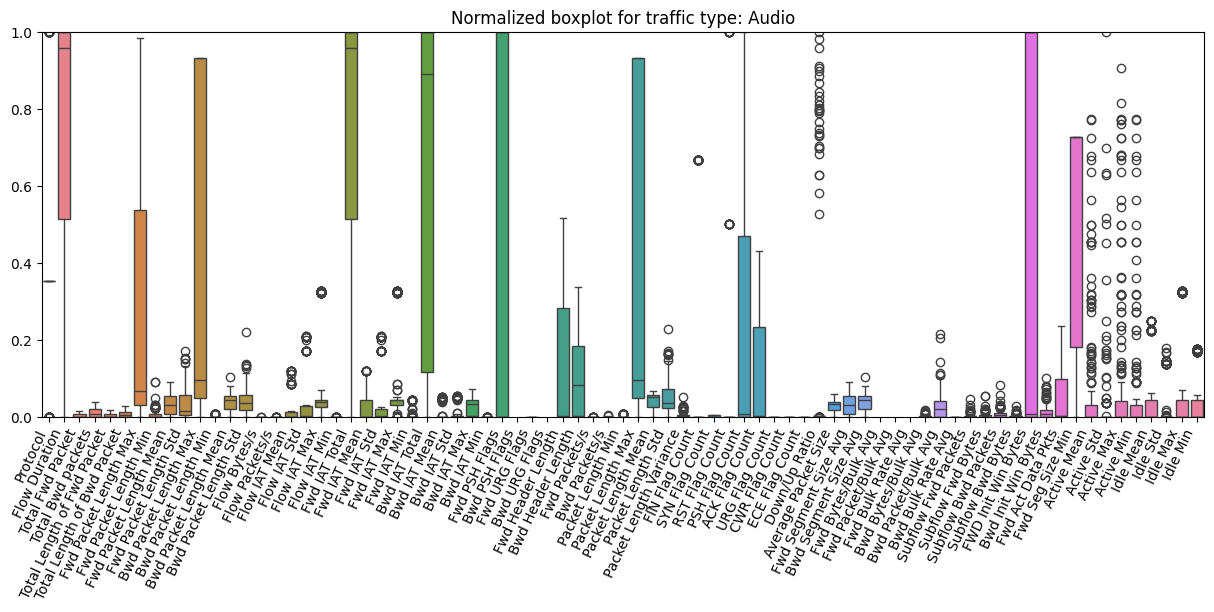

Generating boxplot ...


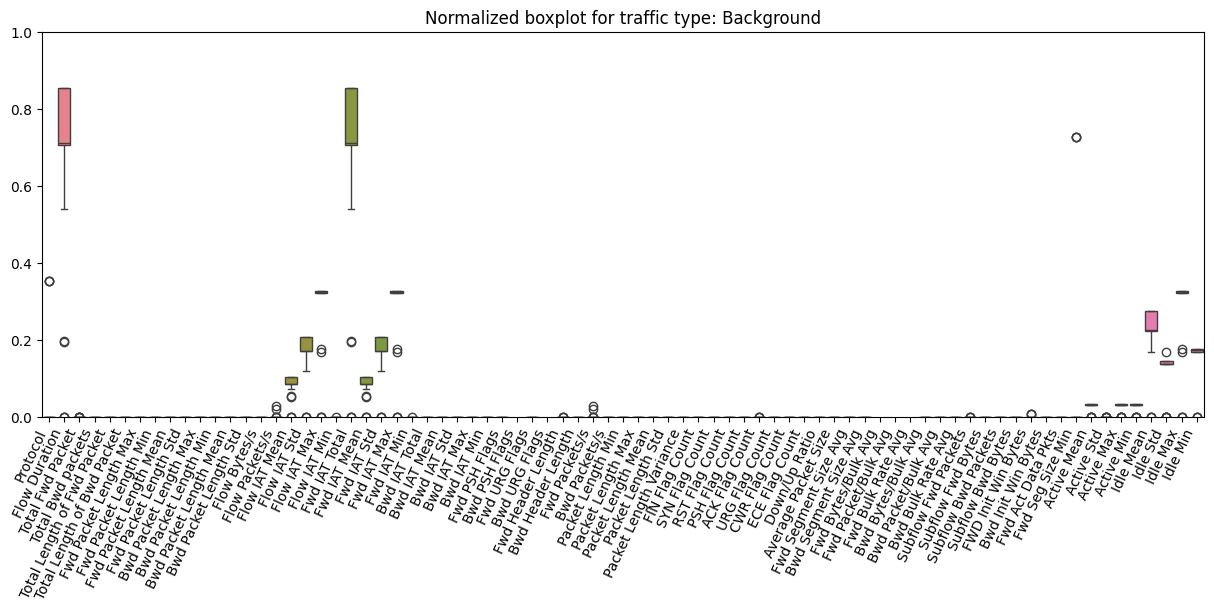

Generating boxplot ...


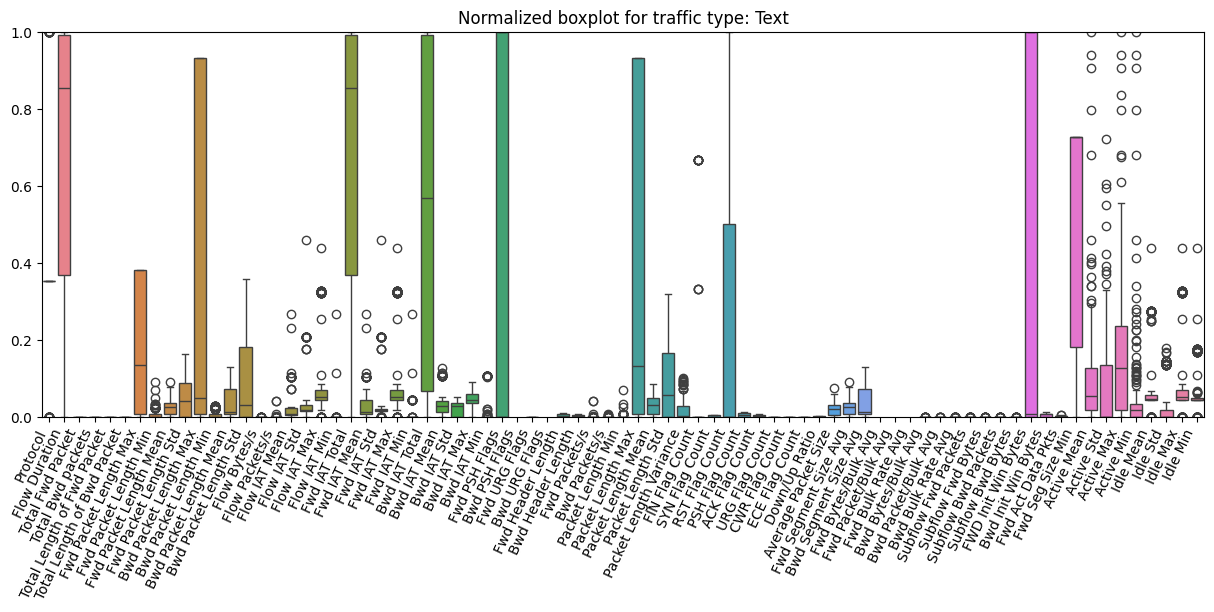

Generating boxplot ...


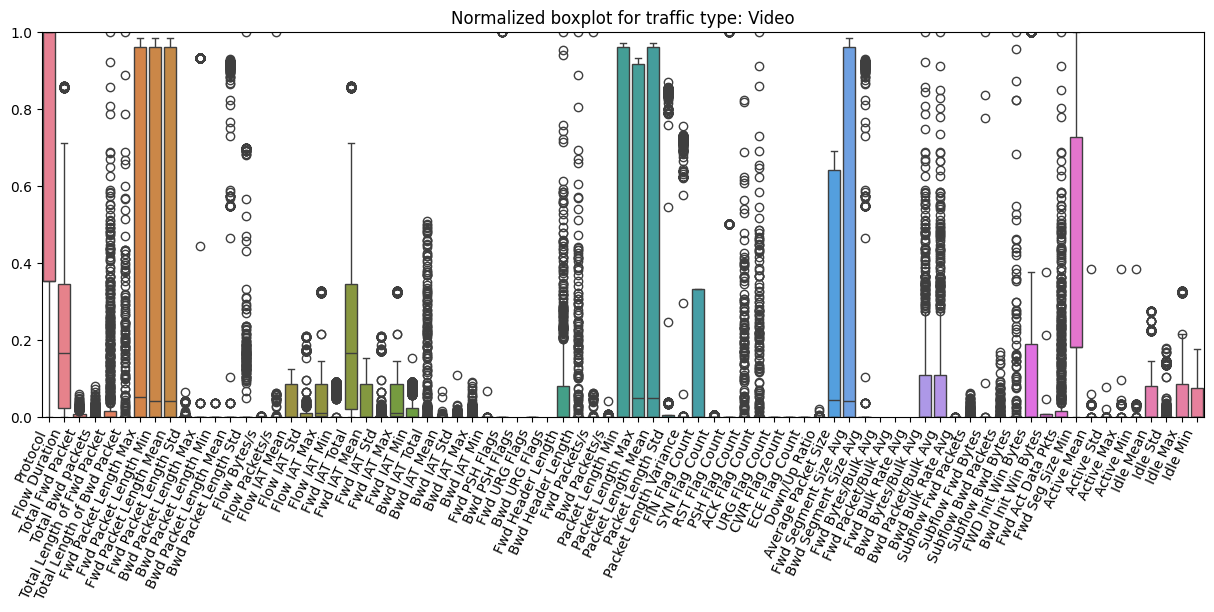

Generating boxplot ...


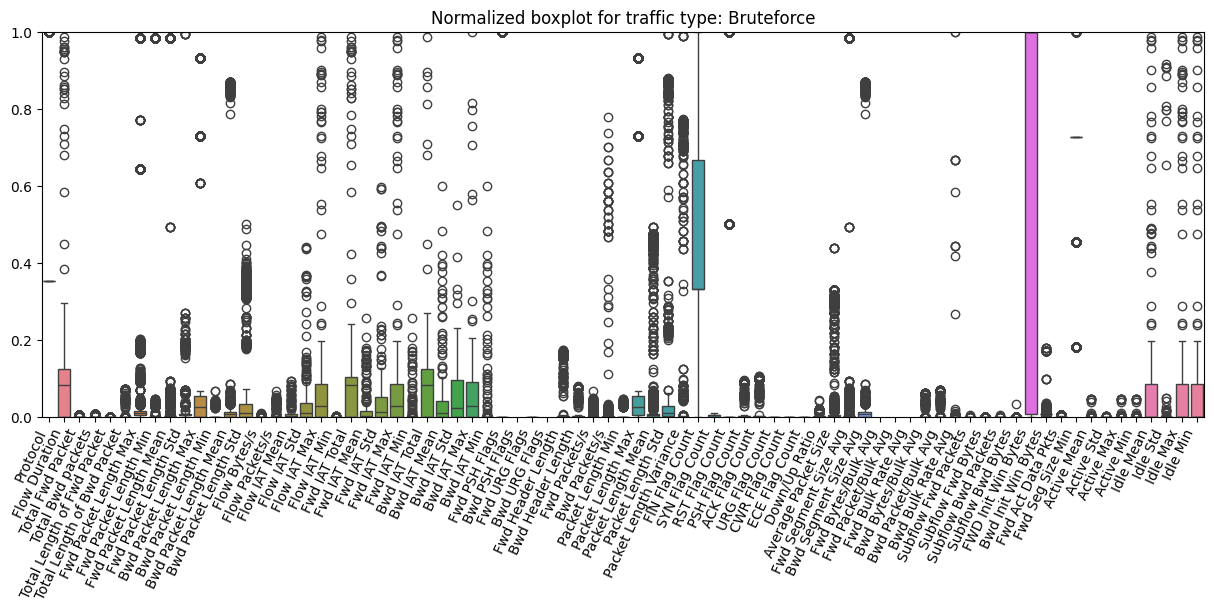

Generating boxplot ...


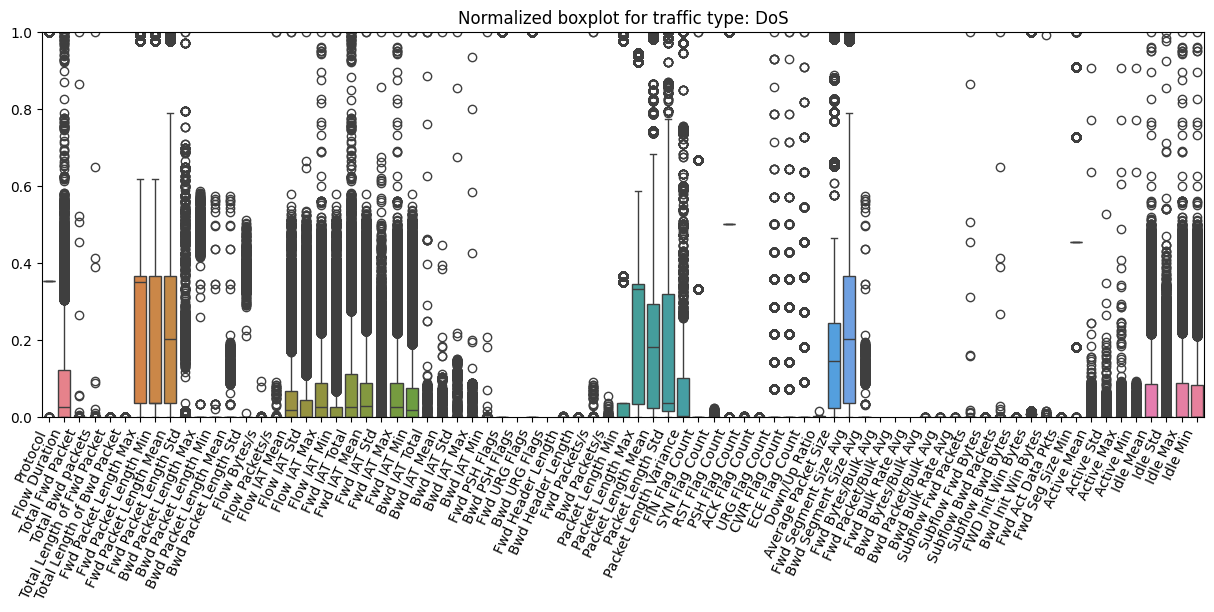

Generating boxplot ...


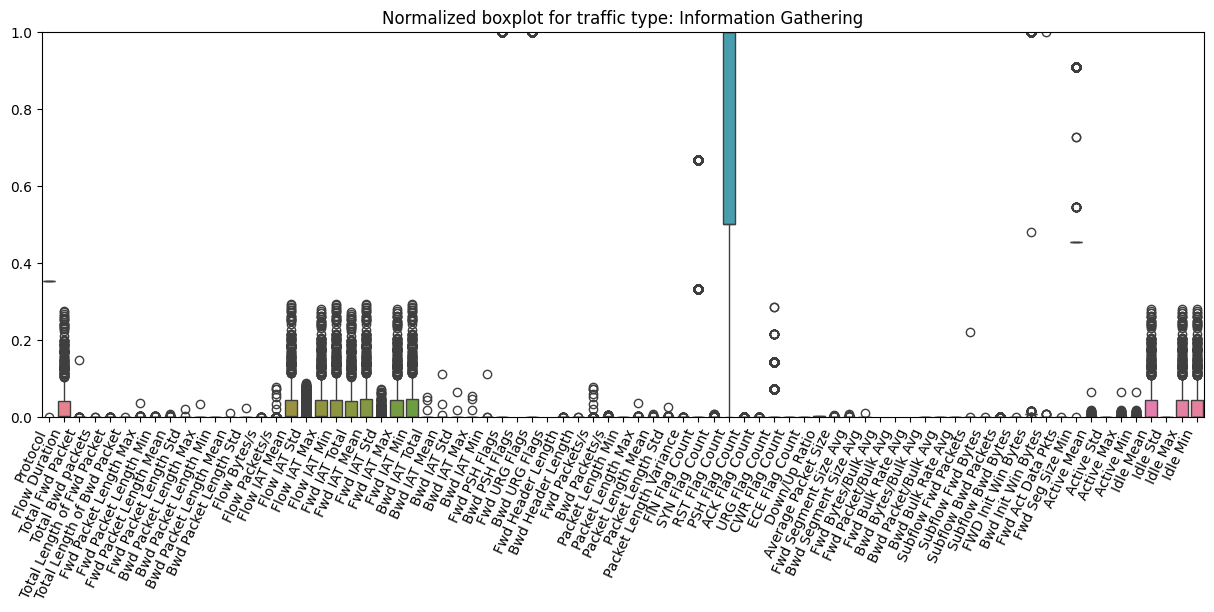

Generating boxplot ...


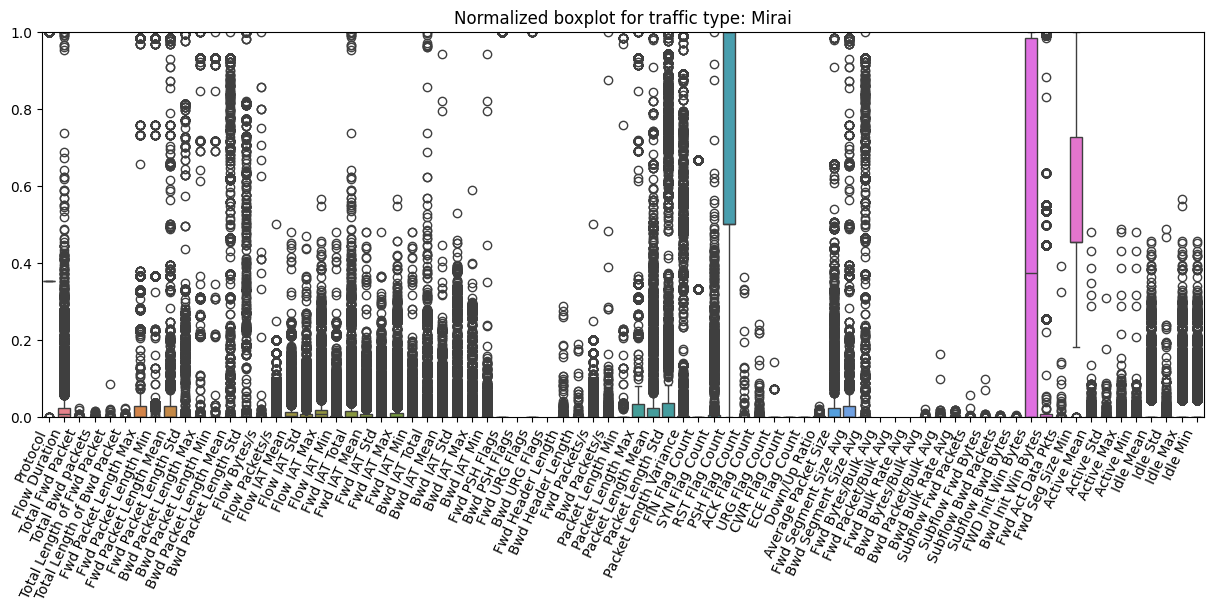

Generating boxplot ...


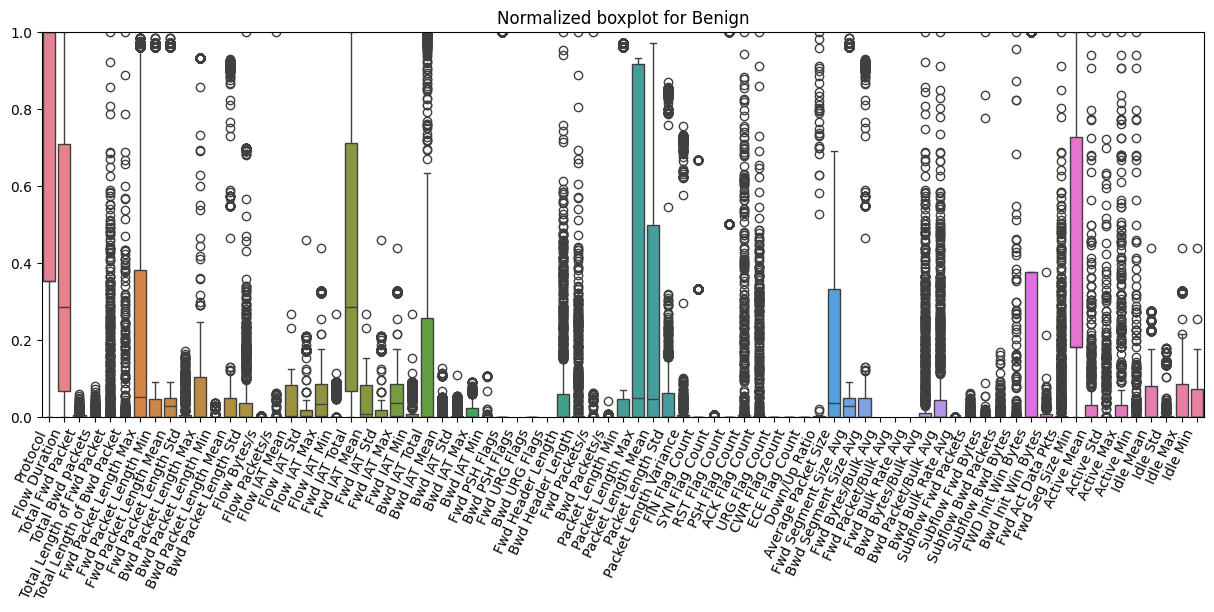

Generating boxplot ...


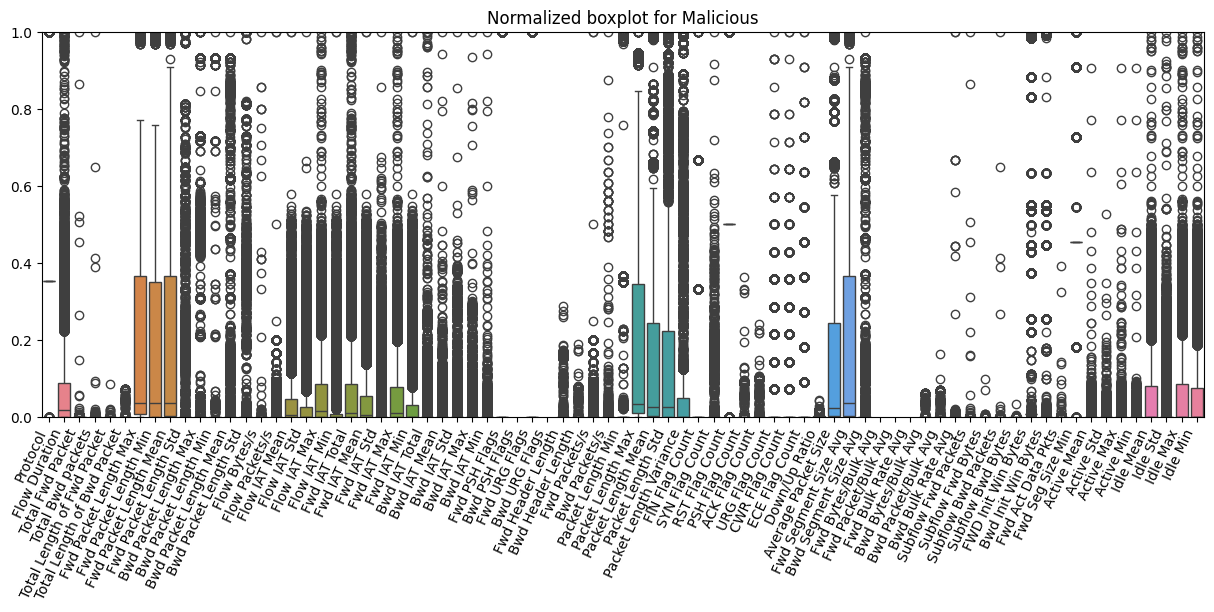

In [153]:
### Present distributions for all metrics for both Benign and Malicious labels
ylim_top = 1
ylim_bot = 0
df_benign = df[df["Label"] == "Benign"]
df_malicious = df[df["Label"] == "Malicious"]

benign_list = ["Audio", "Background", "Text", "Video"]
malicious_list = ["Bruteforce", "DoS", "Information Gathering", "Mirai"]

for ttype in benign_list:
    boxplot(df_benign[df_benign["Traffic Type"] == ttype].drop(columns=TARGET_LABELS), df.drop(columns=TARGET_LABELS), "Normalized boxplot for traffic type: " + ttype, ylim_bot, ylim_top)

for ttype in malicious_list:
    boxplot(df_malicious[df_malicious["Traffic Type"] == ttype].drop(columns=TARGET_LABELS), df.drop(columns=TARGET_LABELS), "Normalized boxplot for traffic type: " + ttype, ylim_bot, ylim_top)

boxplot(df_benign.drop(columns=TARGET_LABELS), df.drop(columns=TARGET_LABELS), "Normalized boxplot for Benign", ylim_bot, ylim_top)
boxplot(df_malicious.drop(columns=TARGET_LABELS), df.drop(columns=TARGET_LABELS), "Normalized boxplot for Malicious", ylim_bot, ylim_top)

In [302]:
# Convert all data to numerical and compute correlations
df_num = labels_to_numerical(df, LABEL_MAPPER)
df_num = ttypes_to_numerical(df_num, TYPES_MAPPER)
df_num = subtypes_to_numerical(df_num, SUBTYPES_MAPPER).select_dtypes(include="number")

cor1 = correlation(df_num)
cor2, important_metrics_label, important_metrics_ttype = correlation(df_num, target=True)
label_barplot = important_metrics_label.copy()
label_barplot.remove("Traffic Type")
label_barplot.remove("Traffic Subtype")
ttype_barplot = important_metrics_ttype.copy()
ttype_barplot.remove("Label")
ttype_barplot.remove("Traffic Subtype")

26 Metrics with high correlation with Label
36 Metrics with high correlation with Traffic Type


Generating heatmap ...


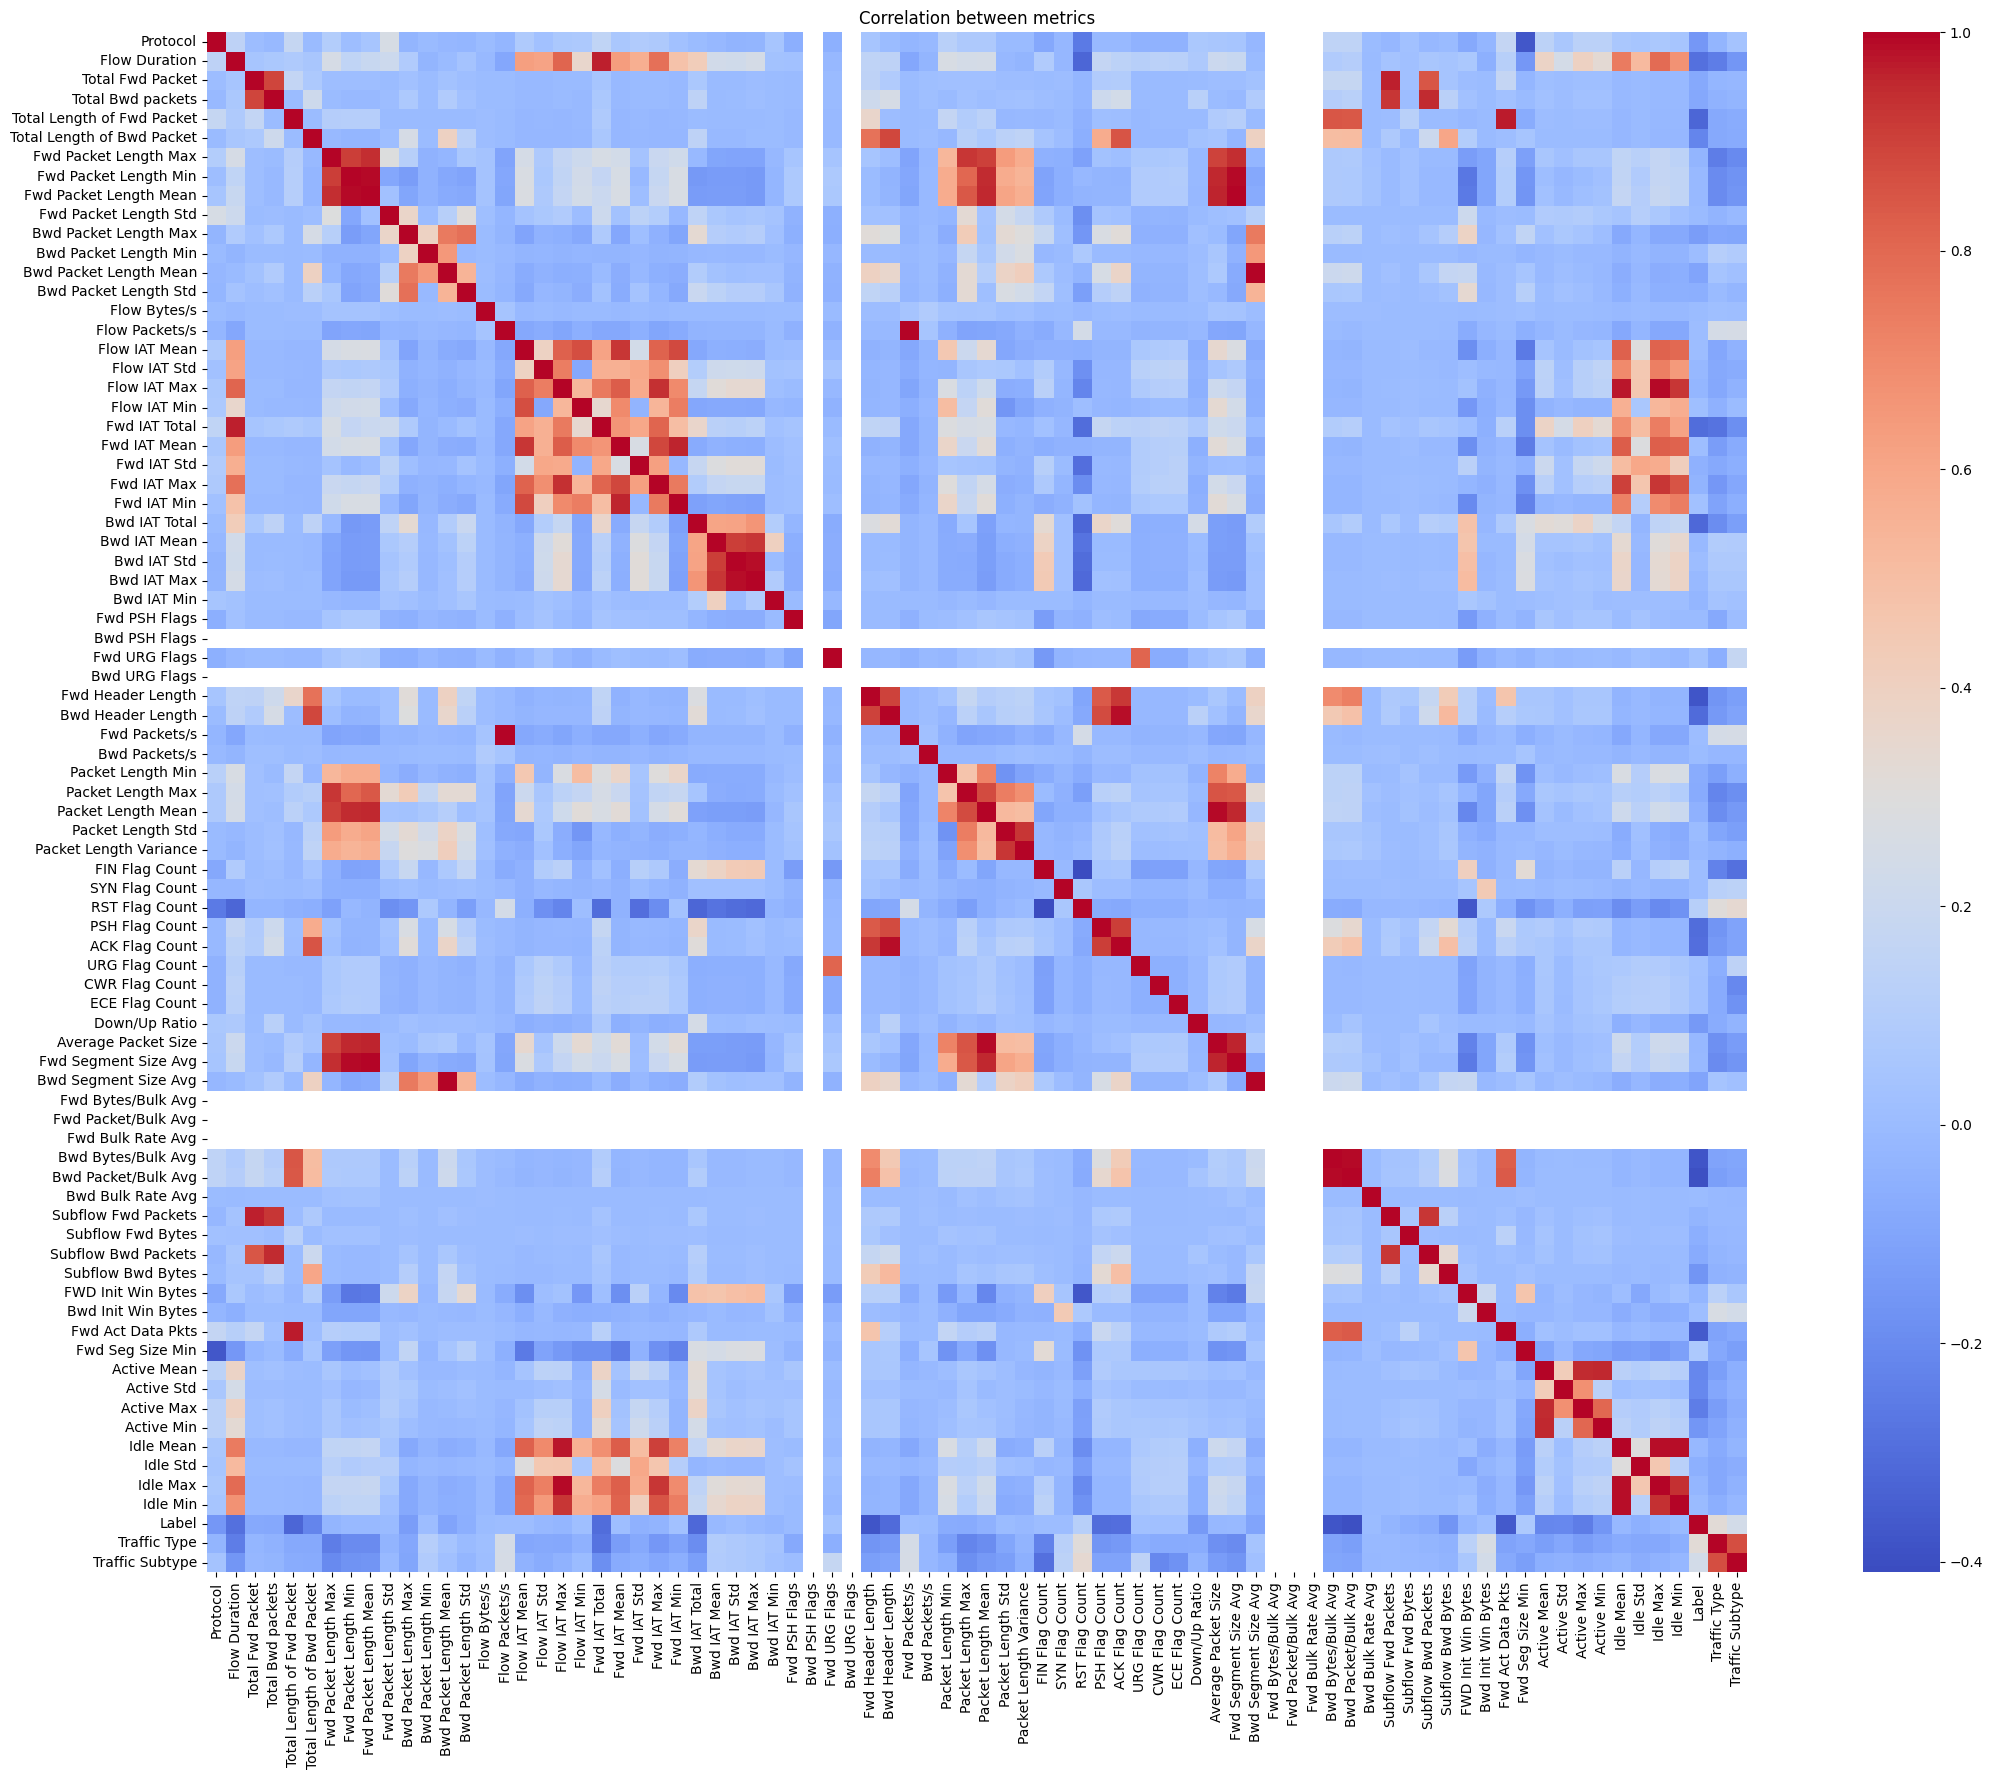

Generating heatmap ...


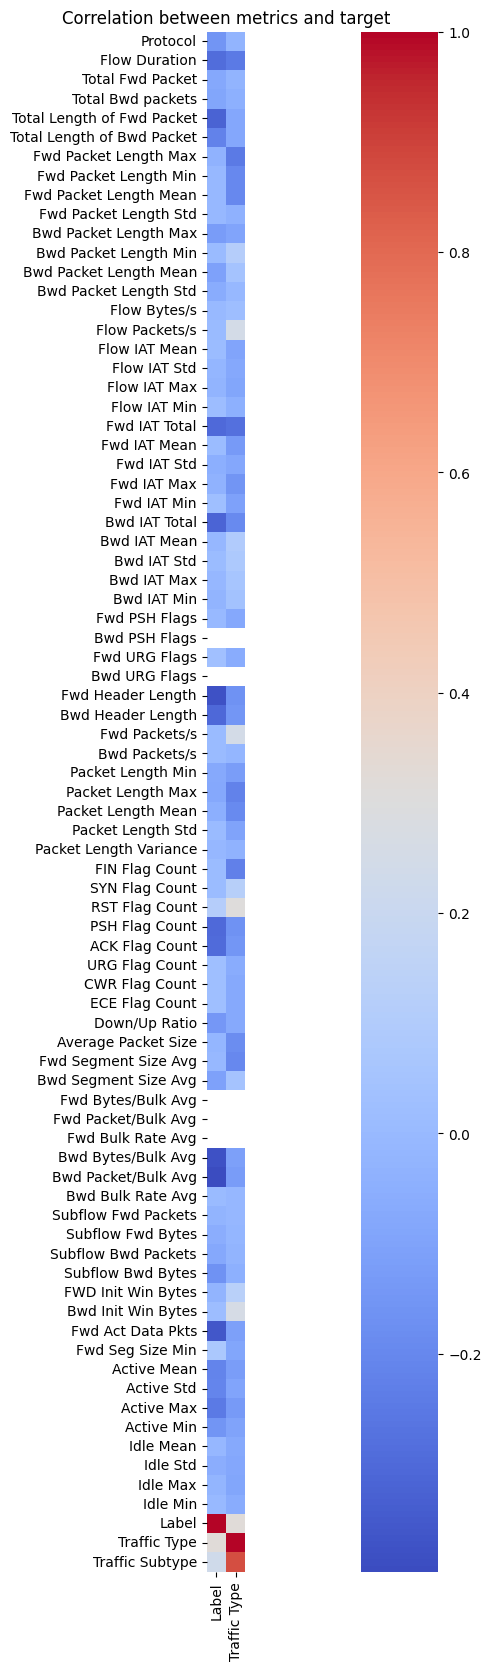

In [304]:
### Create heatmaps
heatmap(cor1, "Correlation between metrics")
heatmap(cor2, "Correlation between metrics and target")

Generating barplot ...


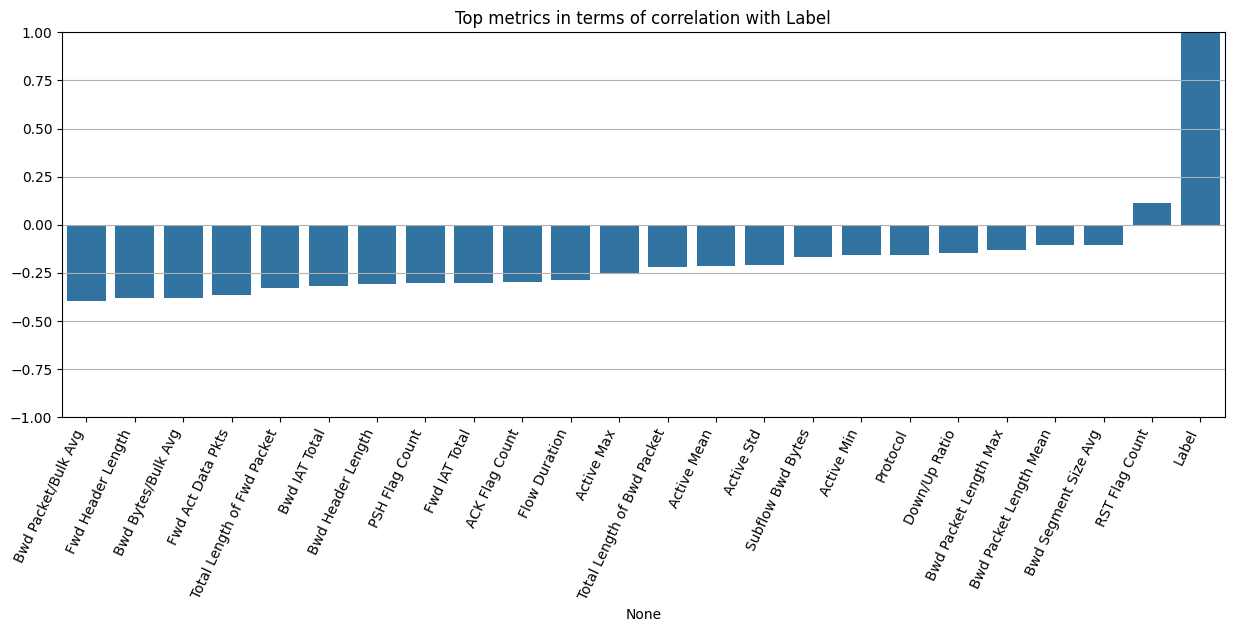

Generating barplot ...


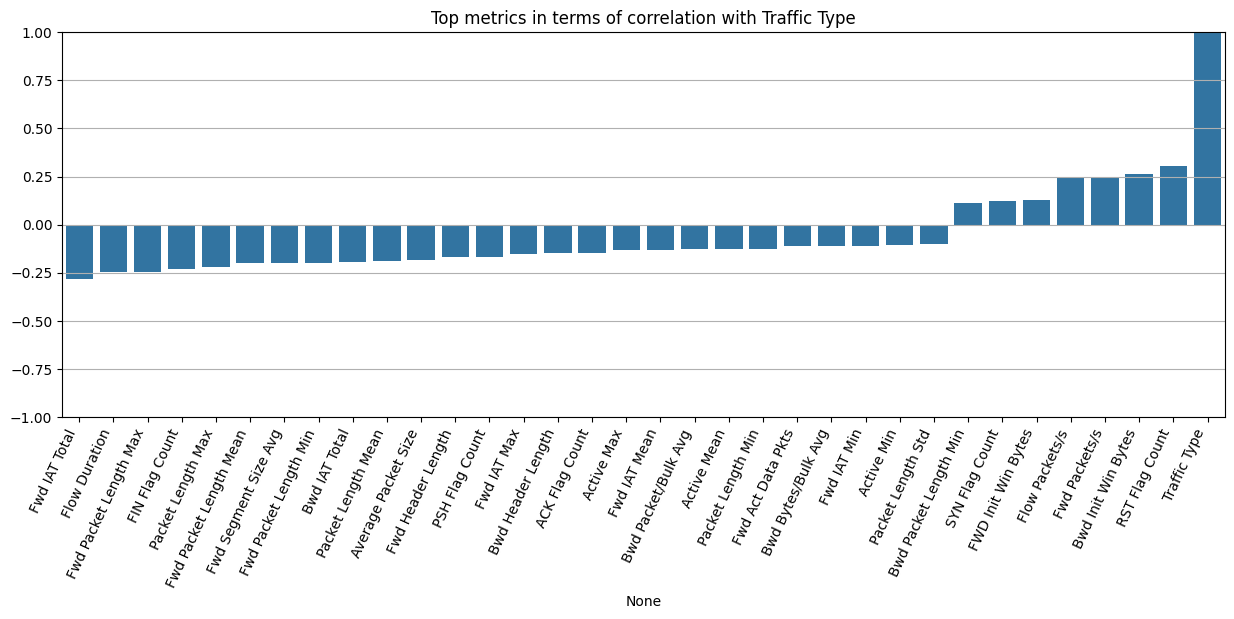

In [305]:
### Showcase top correlations
df_important_metrics_label_count = cor2.filter(items=label_barplot, axis="index").filter(["Label"]).sort_values(by="Label")
barplot(
    df_important_metrics_label_count.index, df_important_metrics_label_count.values.reshape(len(df_important_metrics_label_count.index)),
    "Top metrics in terms of correlation with Label"
)

df_important_metrics_ttype_count = cor2.filter(items=ttype_barplot, axis="index").filter(["Traffic Type"]).sort_values(by="Traffic Type")
barplot(
    df_important_metrics_ttype_count.index, df_important_metrics_ttype_count.values.reshape(len(df_important_metrics_ttype_count.index)),
    "Top metrics in terms of correlation with Traffic Type"
)

In [306]:
### DataFrames with metrics highly correlated with targets, dimension reduction
DIM_TARGET1 = 10
DIM_TARGET2 = 13
df_label = df_num[important_metrics_label]
df_ttype = df_num[important_metrics_ttype]

print("Target Label:")
df_labelDimReduction = dim_reduction(df_label.drop(columns=["Label", "Traffic Type", "Traffic Subtype"]), DIM_TARGET1, "PCA")
df_labelDimReduction["Label"] = df_label["Label"]
df_labelDimReduction["Traffic Type"] = df_label["Traffic Type"]
df_labelDimReduction["Traffic Subtype"] = df_label["Traffic Subtype"]
print("Target Traffic Type:")
df_ttypeDimReduction = dim_reduction(df_ttype.drop(columns=["Label", "Traffic Type", "Traffic Subtype"]), DIM_TARGET2, "PCA")
df_ttypeDimReduction["Label"] = df_label["Label"]
df_ttypeDimReduction["Traffic Type"] = df_label["Traffic Type"]
df_ttypeDimReduction["Traffic Subtype"] = df_label["Traffic Subtype"]


Target Label:
PCA METHOD --> Cumulative variance: 0.9495317213796808
Target Traffic Type:
PCA METHOD --> Cumulative variance: 0.9498706027651025


In [311]:
### Sampling, Clustering with BIRCH, Clustering with HDBSCAN
# Data reduction through sampling
df_label_sampling = sampling(df_labelDimReduction, 0, 0.3, notext=True)
df_ttype_sampling = sampling(df_ttypeDimReduction, 0, 0.3, notext=True)

# Data reduction through BIRCH clustering
print("BIRCH with target: Label")
df_label_BIRCH = BIRCH_clustering(df_labelDimReduction.drop(columns=["Label", "Traffic Type", "Traffic Subtype"]), 100)
df_label_BIRCH["Label"] = df_labelDimReduction["Label"]
print("BIRCH with target: Traffic Type")
df_ttype_BIRCH = BIRCH_clustering(df_ttypeDimReduction.drop(columns=["Label", "Traffic Type", "Traffic Subtype"]), 900)
df_ttype_BIRCH["Traffic Type"] = df_ttypeDimReduction["Traffic Type"]

# Data reduction through HDBSCAN clustering
print("HDBSCAN with target: Label")
df_label_HDBSCAN = HDBSCAN_clustering(df_labelDimReduction.drop(columns=["Label", "Traffic Type", "Traffic Subtype"]), 50)
df_label_HDBSCAN["Label"] = df_labelDimReduction["Label"]
print("HDBSCAN with target: Traffic Type")
df_ttype_HDBSCAN = HDBSCAN_clustering(df_ttypeDimReduction.drop(columns=["Label", "Traffic Type", "Traffic Subtype"]), 25)
df_ttype_HDBSCAN["Traffic Type"] = df_ttypeDimReduction["Traffic Type"]

BIRCH with target: Label
Davies-Bouldin Index: 0.41890284130361427
BIRCH with target: Traffic Type
Davies-Bouldin Index: 0.13715781400096383
HDBSCAN with target: Label
Davies-Bouldin Index: 0.0638083543793167
HDBSCAN with target: Traffic Type
Davies-Bouldin Index: 0.12595267458179374


BIRCH, target = Label:
Problematic Cluster Ratio: 0.18 Problematic Population Ratio: 0.03216060653200914
BIRCH, target = Traffic Type:
Problematic Cluster Ratio: 0.09111111111111111 Problematic Population Ratio: 0.5145369544036614
HDBSCAN, target = Label:
Problematic Cluster Ratio: 0.03666666666666667 Problematic Population Ratio: 0.015318863243734495
HDBSCAN, target = Traffic Type:
Problematic Cluster Ratio: 0.06695156695156695 Problematic Population Ratio: 0.042100264457126016
Problematic Population Ratio should be below 5%!


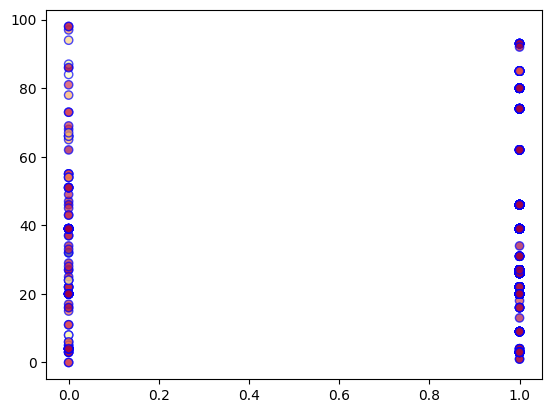

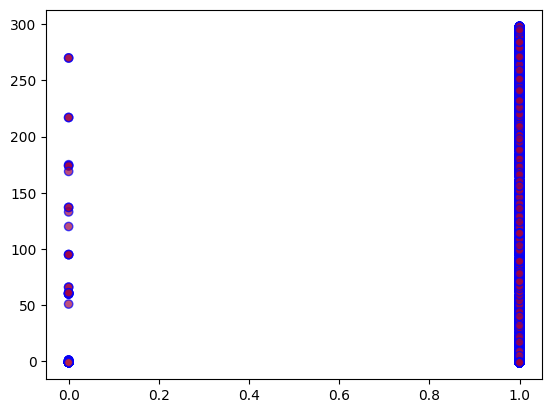

In [313]:
### Visualize clusters
df_label_BIRCH_plot = df_label_BIRCH.copy()
df_label_BIRCH_plot["Traffic Type"] = df_labelDimReduction["Traffic Type"]
df_label_BIRCH_plot["Traffic Subtype"] = df_labelDimReduction["Traffic Subtype"]
df_label_BIRCH_plot = df_label_BIRCH_plot.sample(frac = 0.1)

df_ttype_BIRCH_plot = df_ttype_BIRCH.copy()
df_ttype_BIRCH_plot["Label"] = df_ttypeDimReduction["Label"]
df_ttype_BIRCH_plot["Traffic Subtype"] = df_ttypeDimReduction["Traffic Subtype"]
df_ttype_BIRCH_plot = df_ttype_BIRCH_plot.sample(frac = 0.1)

df_label_HDBSCAN_plot = df_label_HDBSCAN.copy()
df_label_HDBSCAN_plot["Traffic Type"] = df_labelDimReduction["Traffic Type"]
df_label_HDBSCAN_plot["Traffic Subtype"] = df_labelDimReduction["Traffic Subtype"]
df_label_HDBSCAN_plot = df_label_HDBSCAN_plot.sample(frac = 0.1)

df_ttype_HDBSCAN_plot = df_ttype_HDBSCAN.copy()
df_ttype_HDBSCAN_plot["Label"] = df_ttypeDimReduction["Label"]
df_ttype_HDBSCAN_plot["Traffic Subtype"] = df_ttypeDimReduction["Traffic Subtype"]
df_ttype_HDBSCAN_plot = df_ttype_HDBSCAN_plot.sample(frac = 0.1)

print("BIRCH, target = Label:")
evaluate_clusters(df_label_BIRCH, "Label", 2)
print("BIRCH, target = Traffic Type:")
evaluate_clusters(df_ttype_BIRCH, "Traffic Type", 8)
print("HDBSCAN, target = Label:")
evaluate_clusters(df_label_HDBSCAN, "Label", 2)
print("HDBSCAN, target = Traffic Type:")
evaluate_clusters(df_ttype_HDBSCAN, "Traffic Type", 8)
print("Problematic Population Ratio should be below 5%!")

plt.scatter(df_label_BIRCH_plot["Label"], df_label_BIRCH_plot["Cluster"], c = df_label_BIRCH_plot["PC1"], cmap = 'Spectral', alpha = 0.7, edgecolors = 'b')
plt.show()
plt.scatter(df_label_HDBSCAN_plot["Label"], df_label_HDBSCAN_plot["Cluster"], c = df_label_HDBSCAN_plot["PC1"], cmap = 'Spectral', alpha = 0.7, edgecolors = 'b')
plt.show()

In [315]:
print("Amount of Clusters:")
print("BIRCH ALGORITHM\n", df_label_BIRCH.groupby("Cluster").size().reset_index(name="Counts")["Counts"].count(), "\n", df_ttype_BIRCH.groupby("Cluster").size().reset_index(name="Counts")["Counts"].count())
print("HDBSCAN ALGORITHM\n", df_label_HDBSCAN.groupby("Cluster").size().reset_index(name="Counts")["Counts"].count(), "\n", df_ttype_HDBSCAN.groupby("Cluster").size().reset_index(name="Counts")["Counts"].count())

Amount of Clusters:
BIRCH ALGORITHM
 100 
 900
HDBSCAN ALGORITHM
 300 
 702
